## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import net
import logic
from data.load import load_genx

from collections import defaultdict
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

import seaborn as sns
sns.set(font_scale=2)
sns.set_style("ticks")
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [2]:
N_HIDDEN = 256
N_COMM = 64
N_BATCH = 100
MAX_ITEMS = 20

RESTORE = True
SAVE = False

## Model

In [3]:
def build_model(dataset):
    t_features = tf.placeholder(tf.float32, (None, MAX_ITEMS, len(dataset.attrs)))
    t_labels = tf.placeholder(tf.float32, (None, MAX_ITEMS))

    t_in = tf.concat((t_features, tf.expand_dims(t_labels, axis=2)), axis=2)

    cell = tf.contrib.rnn.GRUCell(N_HIDDEN)
    with tf.variable_scope("enc1"):
        states1, hidden1 = tf.nn.dynamic_rnn(cell, t_in, dtype=tf.float32)
    t_hidden = hidden1
    t_msg = tf.nn.relu(net.linear(t_hidden, N_COMM))

    t_expand_msg = tf.expand_dims(t_msg, axis=1)
    t_tile_message = tf.tile(t_expand_msg, (1, MAX_ITEMS, 1))
    t_out_feats = tf.concat((t_tile_message, t_features), axis=2)
    t_pred = tf.squeeze(
        net.mlp(t_out_feats, (N_HIDDEN, 1), (tf.nn.relu, None)))
    t_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=t_labels, logits=t_pred))

    return t_features, t_labels, t_msg, t_pred, t_loss

## Training & Evaluation

In [4]:
random = np.random.RandomState(0)
tf.set_random_seed(0)

dataset = load_genx()
t_features, t_labels, t_msg, t_pred, t_loss = build_model(dataset)
optimizer = tf.train.AdamOptimizer(0.001)
o_train = optimizer.minimize(t_loss)
session = tf.Session()
session.run(tf.global_variables_initializer())

train_lfs = []
for scene_id in dataset.train_ids:
    for label in dataset.labels[scene_id]:
        train_lfs.append(label.lf)
random.shuffle(train_lfs)
        
test_lfs = []
for scene_id in dataset.test_ids:
    for label in dataset.labels[scene_id]:
        test_lfs.append(label.lf)
random.shuffle(test_lfs)

#print dataset.train_ids
#print [logic.pp(lf) for lf in train_lfs]
#print
#print dataset.test_ids
#;print [logic.pp(lf) for lf in test_lfs]

In [5]:
negated = [lf for lf in train_lfs if "not" in logic.tokens(lf)]
print "negation: %f" % (1. * len(negated) / len(train_lfs))

negation: 0.212355


In [5]:
if RESTORE:
    saver = tf.train.Saver()
    saver.restore(session, "saves/model")

In [6]:
def randomize_lf(lf, attrs_by_type):
    if isinstance(lf, str):
        if ":" not in lf:
            return lf
        typ = lf.split(":")[1]
        return random.choice(attrs_by_type[typ])
    return [randomize_lf(l, attrs_by_type) for l in lf]

def sample_envs(dataset, lfs, randomize=False):
    attrs_by_type = defaultdict(list)
    for attr in dataset.attrs:
        typ = attr.split(":")[1]
        attrs_by_type[typ].append(attr)
        
    envs = np.zeros((len(lfs), MAX_ITEMS, len(dataset.attrs)))
    labels = np.zeros((len(lfs), MAX_ITEMS))
    
    i_env = 0
    i_attempt = 0
    while i_env < len(lfs):
        if randomize:
            #template_lf = lfs[random.randint(len(lfs))]
            template_lf = lfs[i_env]
            lf = randomize_lf(template_lf, attrs_by_type)
        else:
            lf = lfs[i_env]
        count = random.randint(MAX_ITEMS)
        for i_item in range(count):
            attrs = np.zeros(len(dataset.attrs))
            for group in attrs_by_type.values():
                val = random.choice(group)
                attrs[dataset.attrs[val]] = 1
            envs[i_env, i_item, :] = attrs
            if logic.eval_lf(attrs, lf, dataset):
                labels[i_env, i_item] = 1
        i_attempt += 1
        if (not labels[i_env, :].any()) or labels[i_env, :].all():
            # reset!
            envs[i_env, :, :] = 0
            labels[i_env, :] = 0
            if i_attempt < 10:
                continue
        i_env += 1
        i_attempt += 1
    
    return envs, labels

def sample_annotated(dataset, scene_ids):
    envs = np.zeros((len(scene_ids), MAX_ITEMS, len(dataset.attrs)))
    labels = np.zeros((len(scene_ids), MAX_ITEMS))
    for i_env, scene_id in enumerate(scene_ids):
        scene = dataset.scenes[scene_id]
        i_item = 0
        for target in scene.targets:
            for prop in target.props:
                envs[i_env, i_item, dataset.attrs[prop]] = 1
            labels[i_env, i_item] = 1
            i_item += 1
            
        for distractor in scene.distractors:
            for prop in distractor.props:
                envs[i_env, i_item, dataset.attrs[prop]] = 1
            i_item += 1
            
    return envs, labels

In [7]:
acc_history = []
exact_history = []
def eval_labeled():
    scene_ids = dataset.train_ids
    acc = 0.
    exact = 0.
    for i in range(0, len(scene_ids), N_BATCH):
        batch_ids = scene_ids[i:i+N_BATCH]
        envs, labels = sample_annotated(dataset, batch_ids)
        preds, = session.run([t_pred], {t_features: envs, t_labels: labels})
        match = (preds > 0) == labels
        acc += np.sum(np.mean(match, axis=1))
        exact += np.sum(np.all(match, axis=1))
    acc /= len(scene_ids)
    exact /= len(scene_ids)
    acc_history.append(acc)
    exact_history.append(exact)
    
    from IPython import display
    display.clear_output(wait=True)
    plt.clf()
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(range(len(acc_history)), acc_history)
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(range(len(exact_history)), exact_history)
    plt.show()

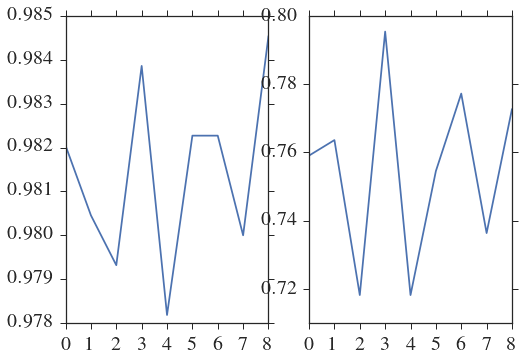

KeyboardInterrupt: 

In [9]:
random = np.random.RandomState(1)

for epoch in range(100):
    loss = 0
    acc = 0
    ex = 0
    for t in range(100):
        batch_lfs = [train_lfs[random.randint(len(train_lfs))] for _ in range(N_BATCH)]
        envs, labels = sample_envs(dataset, batch_lfs, randomize=True)
        l, preds, _ = session.run(
                [t_loss, t_pred, o_train],
                {t_features: envs, t_labels: labels})
        match = (preds > 0) == labels
        a = np.mean(match)
        e = np.mean(np.all(match, axis=1))
        loss += l
        acc += a
        ex += e
        
    eval_labeled()

In [ ]:
if SAVE:
    saver = tf.train.Saver()
    saver.save(session, "saves/model")

## Analysis

In [9]:
n_sample = 10

def literal_pred(item, stim_env, stim_labels):
    if not item.any():
        return False
    return any(
        (stim_env[0, j, :] == item).all() and stim_labels[0, j] == 1
        for j in range(stim_env.shape[1])
    )

def random_pred(item):
    if not item.any():
        return False
    return random.randint(2)

def count_equiv(msg, n_sample, predictors, n_agreements, n_matches, n_items, scene_ids):
    tile_msg = np.asarray([msg for _ in range(n_sample)])

    envs, _ = sample_annotated(dataset, random.choice(scene_ids, size=n_sample).tolist())
    model_preds, = session.run([t_pred], {t_features: envs, t_msg: tile_msg})
    for name, predictor in predictors.items():
        preds = np.zeros((n_sample, MAX_ITEMS))
        nit = 0
        nit_t = 0
        for i_samp in range(n_sample):
            for i_item in range(MAX_ITEMS):
                preds[i_samp, i_item] = predictor(envs[i_samp, i_item, :])
                if envs[i_samp, i_item, :].any():
                    nit_t += 1
                    if preds[i_samp, i_item] == (model_preds > 0)[i_samp, i_item]:
                        nit += 1
                
            #print preds[i_samp, :].astype(int)
            #print (model_preds > 0)[i_samp, :].astype(int)
            #print
                
        n_agreements[name] += np.mean(np.all((model_preds > 0) == preds, axis=1))
        n_matches[name] += ((model_preds > 0) == preds).all()
        n_items[name] += 1. * nit / nit_t
        #n_items[name] += np.mean((model_preds > 0) == preds and np.any(envs, axis=2))
        #n_matches[name] += (1 if (np.mean(np.all((model_preds > 0) == preds, axis=1)) >= 0.9) else 0)

def check_agreement(_sentinel=None, scene_ids=None, lfs=None, sample_ids=None):
    assert _sentinel is None
    assert not (scene_ids is None and lfs is None)
    assert sample_ids is not None
    matches = []
    
    n_agreements = defaultdict(lambda: 0)
    n_matches = defaultdict(lambda: 0)
    n_items = defaultdict(lambda: 0)
    n_successes = 0
    n_ref_successes = 0
    
    if scene_ids is not None:
        all_stim_envs, all_stim_labels = sample_annotated(dataset, scene_ids)
        n_use = len(scene_ids)
    else:
        all_stim_envs, all_stim_labels = sample_envs(dataset, lfs)
        n_use = len(lfs)
    
    for i_stim in range(n_use):
        stim_env = all_stim_envs[i_stim:i_stim+1, ...]
        stim_labels = all_stim_labels[i_stim:i_stim+1, ...]
        if scene_ids is not None:
            scene_labels = [l.lf for l in dataset.labels[scene_ids[i_stim]]]
        else:
            scene_labels = [lfs[i_stim]]
        
        lf_counts = defaultdict(lambda: [None, 0])
        for lf in scene_labels:
            lf_counts[str(lf)][0] = lf
            lf_counts[str(lf)][1] += 1
        random_lf = scene_labels[random.randint(len(scene_labels))]
        consensus_lf = max(lf_counts.values(),
                key=lambda x: x[1])[0]
        shortest_lf = min(lf_counts.values(),
                key=lambda x: len(logic.tokens(x[0])))[0]
        predictors = {
            #"random": lambda item: logic.eval_lf(item, random_lf, dataset),
            "random": lambda item: random_pred(item),
            "consensus": lambda item: logic.eval_lf(item, consensus_lf, dataset),
            "shortest": lambda item: logic.eval_lf(item, shortest_lf, dataset),
            "literal": lambda item: literal_pred(item, stim_env, stim_labels)
        }
        
        stim_lf_pred = [logic.eval_lf(stim_env[0, i_item, :], lf, dataset) for i_item in range(MAX_ITEMS)]          
        msg, stim_pred = session.run([t_msg, t_pred], {t_features: stim_env, t_labels: stim_labels})
        msg = msg[0, :]
        
        if np.all(stim_labels == stim_lf_pred):
            n_ref_successes += 1
        if ((stim_pred > 0) == stim_labels).all():
            n_successes += 1
        
        count_equiv(msg, n_sample, predictors, n_agreements, n_matches, n_items, sample_ids)
            
    print "ref accuracy: %0.2f" % (1. * n_ref_successes / n_use)
    print "model accuracy: %0.2f" % (1. * n_successes / n_use)
    print "scene agreement:  "
    for name, score in n_agreements.items():
        print "    %s: %0.2f" % (name, 1. * score / n_use)
    print "message agreement:"
    for name, score in n_matches.items():
        print "    %s: %0.2f" % (name, 1. * score / n_use)
    print "item agreement:"
    for name, score in n_items.items():
        print "    %s: %0.2f" % (name, 1. * score / n_use)
        
def check_transform(lf_groups, sample_ids, lf_transform=None, msg_transform=None, enforce_equiv=False,
            enforce_init=False, require_trans=0):
    assert lf_transform is not None
    pairs = []
    i_lf = 0
    i_attempt = 0
    agree_stim = 0.
    agree_all = defaultdict(lambda: 0.)
    agree_all_partial = defaultdict(lambda: 0.)
    agree_all_item = defaultdict(lambda: 0)
    while len(pairs) < len(lf_groups):
        if enforce_equiv or enforce_init:
            lf_group = lf_groups[random.randint(len(lf_groups))]
        else:
            lf_group = lf_groups[i_lf]
            
        #stim_env, _ = sample_envs(dataset, [lf_group[0]])
        stim_env, _ = sample_annotated(dataset, [random.choice(sample_ids)])
        trans_lf = lf_transform(lf_group)
        stim_labels = [[logic.eval_lf(stim_env[0, i, :], lf, dataset) for i in range(MAX_ITEMS)] for lf in lf_group]
        stim_labels = np.asarray(stim_labels)
        trans_labels = [[logic.eval_lf(stim_env[0, i, :], trans_lf, dataset) for i in range(MAX_ITEMS)]]
        trans_labels = np.asarray(trans_labels)
        if trans_labels.sum() < require_trans:
            continue
        
        msgs, preds = session.run(
            [t_msg, t_pred],
            {t_features: np.tile(stim_env, (len(lf_group), 1, 1)), t_labels: stim_labels})
        
        if msg_transform is None:
            trans_msg, trans_preds = session.run([t_msg, t_pred], {t_features: stim_env, t_labels: trans_labels})
            trans_msg = trans_msg[0, :]
        else:
            trans_msg = msg_transform(msgs)
            trans_preds, = session.run([t_pred], {t_features: stim_env, t_msg: [trans_msg]})
            
        n_trans_ag = defaultdict(lambda: 0)
        n_trans_match = defaultdict(lambda: 0)
        n_trans_item = defaultdict(lambda: 0)
        count_equiv(
                trans_msg, 10, {
                    "human": lambda item: logic.eval_lf(item, trans_lf, dataset),
                    "literal": lambda item: literal_pred(item, stim_env, trans_labels),
                    "literal-neg": lambda item: not literal_pred(item, stim_env, trans_labels),
                    "random": lambda item: random_pred(item)
                },
                n_trans_ag, n_trans_match, n_trans_item, sample_ids)
            
        if enforce_equiv or enforce_init:
            i_attempt += 1
            n_ag = defaultdict(lambda: 0)
            n_match = defaultdict(lambda: 0)
            n_item = defaultdict(lambda: 0)
            for i_msg in range(len(lf_group)):
                count_equiv(
                        msgs[i_msg, ...], 10, {"_": lambda item: logic.eval_lf(item, lf_group[i_msg], dataset)},
                        n_ag, n_match, n_item, sample_ids)
            if n_match["_"] < len(lf_group):
                continue
            if enforce_equiv and n_trans_match["human"] < 1:
                continue
            if len(pairs) % 100 == 0:
                print len(pairs), "/", len(lf_groups)
        
        if ((trans_preds > 0) == trans_labels).all():
            agree_stim += 1
        for k in n_trans_match:
            agree_all[k] += n_trans_match[k]
            agree_all_partial[k] += n_trans_ag[k]
            agree_all_item[k] += n_trans_item[k]
            
        pairs.append((msgs, trans_msg, lf_group))
        i_lf += 1
        i_attempt = 0
        
    #print "agree after transform (stim): %0.2f" % (agree_stim / len(lf_groups))
    #print "agree after transform (all): %0.2f %0.2f" % (agree_all / len(lf_groups), (agree_all_partial / len(lf_groups)))
    n_use = len(lf_groups)
    print "agree after transform (stim): %0.2f" % (agree_stim / n_use)
    print "scene agreement:  "
    for name, score in agree_all_partial.items():
        print "    %s: %0.2f" % (name, 1. * score / n_use)
    print "message agreement:"
    for name, score in agree_all.items():
        print "    %s: %0.2f" % (name, 1. * score / n_use)
    print "item agreement:"
    for name, score in agree_all_item.items():
        print "    %s: %0.2f" % (name, 1. * score / n_use)
    
    return pairs

In [11]:
from sklearn.decomposition import PCA

def visualize(matches, dest=None):
    messages = np.asarray([m[0] for m in matches])
    proj_msgs = PCA(2).fit_transform(messages)
    
    if len(matches[0]) == 3:
        colors = [m[2] for m in matches]
    else:
        colors = None
    
    plt.figure()
    plt.scatter(proj_msgs[:, 0], proj_msgs[:, 1], c=colors, s=50, linewidth=2)
    for i, m in enumerate(matches):
        lf = m[1]
        plt.text(proj_msgs[i, 0], proj_msgs[i, 1], logic.pp(lf))
    if dest is not None:
        plt.savefig(dest)
    plt.show()

In [12]:
random = np.random.RandomState(2)

all_scene_ids = dataset.test_ids

check_agreement(scene_ids=all_scene_ids, sample_ids=dataset.test_ids)

ref accuracy: 1.00
model accuracy: 0.84
scene agreement:  
    consensus: 0.52
    literal: 0.30
    random: 0.00
    shortest: 0.50
message agreement:
    consensus: 0.23
    literal: 0.07
    random: 0.00
    shortest: 0.23
item agreement:
    consensus: 0.89
    literal: 0.77
    random: 0.49
    shortest: 0.89


In [13]:
random = np.random.RandomState(3)

primitive_scene_ids = []
for scene_id in dataset.test_ids:
    labels = dataset.labels[scene_id]
    if any(isinstance(label.lf, str) for label in labels):
        primitive_scene_ids.append(scene_id)
        
check_agreement(scene_ids=primitive_scene_ids, sample_ids=dataset.test_ids)

ref accuracy: 1.00
model accuracy: 0.89
scene agreement:  
    consensus: 0.51
    literal: 0.46
    random: 0.00
    shortest: 0.50
message agreement:
    consensus: 0.22
    literal: 0.06
    random: 0.00
    shortest: 0.22
item agreement:
    consensus: 0.92
    literal: 0.92
    random: 0.51
    shortest: 0.91


In [10]:
random = np.random.RandomState(4)

fit_lfs = [[lf] for lf in train_lfs[:500]]
eval_lfs = [[lf] for lf in test_lfs]
eval_lfs = [e for e in eval_lfs if e not in fit_lfs]

lf_negate = lambda lfs: ["not", lfs[0]]

print "fit"

pairs = []
for i_lf in range(0, len(fit_lfs), 500):
    args = fit_lfs[i_lf:i_lf+500]
    pairs += check_transform(
            args, dataset.train_ids, lf_transform=lf_negate)
x = np.asarray([p for (p,), n, l in pairs])
y = np.asarray([n for (p,), n, l in pairs])
op, residuals, rank, _ = np.linalg.lstsq(x, y)
print residuals, rank

equiv_pairs = []
for i_lf in range(0, len(fit_lfs), 500):
    args = fit_lfs[i_lf:i_lf+500]
    equiv_pairs += check_transform(
            args, dataset.train_ids, lf_transform=lf_negate, enforce_equiv=True)
    
ex = np.asarray([p for (p,), n, l in equiv_pairs])
ey = np.asarray([n for (p,), n, l in equiv_pairs])
eop, residuals, rank, _ = np.linalg.lstsq(ex, ey)
print residuals, rank

print
print "eval"

_ = check_transform(eval_lfs, dataset.test_ids, lf_transform=lf_negate, msg_transform=lambda msgs: op.T.dot(msgs[0]))
#_ = check_transform(eval_lfs, dataset.test_ids, lf_transform=lf_negate, msg_transform=lambda msgs: eop.T.dot(msgs[0]))
#
#_ = check_transform(
#        eval_lfs, dataset.test_ids, lf_transform=lf_negate, msg_transform=lambda msgs: op.T.dot(msgs[0]),
#        enforce_init=True)
_ = check_transform(
        eval_lfs, dataset.test_ids, lf_transform=lf_negate, msg_transform=lambda msgs: eop.T.dot(msgs[0]),
        enforce_init=True)

fit
agree after transform (stim): 0.86
scene agreement:  
    literal-neg: 0.00
    literal: 0.10
    random: 0.00
    human: 0.51
message agreement:
    literal-neg: 0.00
    literal: 0.05
    random: 0.00
    human: 0.16
item agreement:
    literal-neg: 0.53
    literal: 0.47
    random: 0.50
    human: 0.91
[] 43
0 / 500
100 / 500
200 / 500
300 / 500
400 / 500
agree after transform (stim): 1.00
scene agreement:  
    literal-neg: 0.00
    literal: 0.05
    random: 0.01
    human: 1.00
message agreement:
    literal-neg: 0.00
    literal: 0.00
    random: 0.00
    human: 1.00
item agreement:
    literal-neg: 0.54
    literal: 0.46
    random: 0.50
    human: 1.00
[] 43

eval
agree after transform (stim): 0.71
scene agreement:  
    literal-neg: 0.00
    literal: 0.10
    random: 0.00
    human: 0.42
message agreement:
    literal-neg: 0.00
    literal: 0.06
    random: 0.00
    human: 0.07
item agreement:
    literal-neg: 0.55
    literal: 0.45
    random: 0.50
    human: 0.88
0 / 41

In [29]:
_ = check_transform(
        eval_lfs, dataset.test_ids, lf_transform=lf_negate, msg_transform=lambda msgs: eop.T.dot(msgs[0]),
        enforce_init=True)

[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0]

[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0]

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0]

[0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0]

[0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 1 0 0 1 1 1 1 

KeyboardInterrupt: 

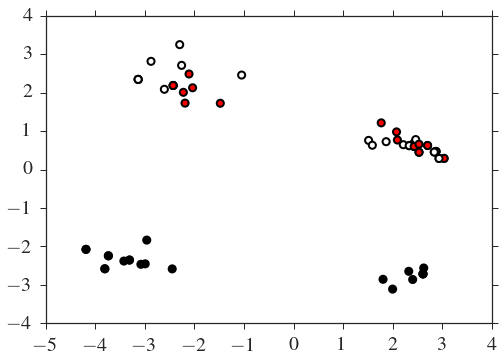

In [15]:
points = []
labels = []
colors = []
lf_counts = defaultdict(lambda: 0)

candidates = ("red:color", ["or", "green:color", "blue:color"])

for p, n, l in equiv_pairs:
    if l[0] in candidates and lf_counts[str(l[0])] < 20:
        if False: #lf_counts[str(l[0])] == 0:
            labels.append(l[0])
            labels.append(lf_negate(l))
            labels.append("")
        else:
            labels += ["", "", ""]
            
        points.append(p[0])
        colors.append("k")
        
        points.append(n)
        colors.append("w")
        
        points.append(eop.T.dot(p[0]))
        colors.append("r")
        
        lf_counts[str(l[0])] += 1
        
visualize(zip(points, labels, colors), dest="fig_not.pdf")

In [16]:
random = np.random.RandomState(5)

fit_lfs = train_lfs[:500]
fit_lfs_2 = list(fit_lfs)
random.shuffle(fit_lfs_2)
eval_lfs = test_lfs
eval_lfs_2 = list(eval_lfs)
random.shuffle(eval_lfs_2)

lf_disjoin = lambda lfs: ["or", lfs[0], lfs[1]]

print "fit"

pairs = []
for i_lf in range(0, len(fit_lfs), 500):
    args = zip(fit_lfs[i_lf:i_lf+500], fit_lfs_2[i_lf:i_lf+500])
    pairs += check_transform(
            args, dataset.train_ids, lf_transform=lf_disjoin, enforce_equiv=False)
x1 = np.asarray([p1 for (p1, p2), n, l in pairs])
x2 = np.asarray([p2 for (p1, p2), n, l in pairs])
y = np.asarray([n for pp, n, l in pairs])
op, residuals, rank, _ = np.linalg.lstsq((x1 + x2) / 2, y)
print residuals, rank

equiv_pairs = []
for i_lf in range(0, len(fit_lfs), 500):
    args = zip(fit_lfs[i_lf:i_lf+500], fit_lfs_2[i_lf:i_lf+500])
    equiv_pairs += check_transform(
            args, dataset.train_ids, lf_transform=lf_disjoin, enforce_equiv=True)
ex1 = np.asarray([p1 for (p1, p2), n, l in equiv_pairs])
ex2 = np.asarray([p2 for (p1, p2), n, l in equiv_pairs])
ey = np.asarray([n for pp, n, l in equiv_pairs])
eop, residuals, rank, _ = np.linalg.lstsq((ex1 + ex2) / 2, ey)
print residuals, rank

print
print "eval"

_ = check_transform(
        zip(eval_lfs, eval_lfs_2), dataset.test_ids, lf_transform=lf_disjoin, 
        msg_transform=lambda msgs: op.T.dot((msgs[0] + msgs[1])/2))
_ = check_transform(
        zip(eval_lfs, eval_lfs_2), dataset.test_ids, lf_transform=lf_disjoin, 
        msg_transform=lambda msgs: eop.T.dot((msgs[0] + msgs[1])/2), enforce_init=True)

fit
agree after transform (stim): 0.84
scene agreement:  
    literal: 0.21
    random: 0.00
    human: 0.45
message agreement:
    literal: 0.11
    random: 0.00
    human: 0.13
item agreement:
    literal: 0.63
    random: 0.50
    human: 0.90
[] 42
0 / 500


KeyboardInterrupt: 

In [ ]:
points = []
labels = []
colors = []
lf_counts = defaultdict(lambda: 0)

#candidates = ("red:color", ["or", "green:color", "blue:color"])
candidates = ("red:color", "yellow:color", "blue:color")

count = 5

#random.shuffle(equiv_pairs)
for p, n, l in equiv_pairs:
    if l[0] in candidates and l[1] in candidates and l[0] != l[1]:
        if lf_counts[l[0]] < count:
            points.append(p[0])
            #labels.append(l[0])
            labels.append("")
            colors.append("k")
            lf_counts[l[0]] += 1
        if lf_counts[l[1]] < count:
            points.append(p[1])
            #labels.append(l[1])
            labels.append("")
            colors.append("k")
            lf_counts[l[1]] += 1
        if lf_counts[str(lf_disjoin(l))] < count:
            points.append(n)
            #labels.append(lf_disjoin(l))
            labels.append("")
            colors.append("w")
            lf_counts[str(lf_disjoin(l))] += 1
            
            points.append(eop.T.dot((p[0] + p[1]) / 2))
            labels.append("")
            colors.append("r")
        
visualize(zip(points, labels, colors), dest="fig_or.pdf")

In [ ]:
random = np.random.RandomState(6)

#fit_lfs = train_lfs[:500]
fit_lfs = [lf for lf in train_lfs if len(logic.tokens(lf)) <= 3]
fit_lfs = fit_lfs[:500]
fit_lfs_2 = list(fit_lfs)
random.shuffle(fit_lfs_2)
eval_lfs = test_lfs
eval_lfs_2 = list(eval_lfs)
random.shuffle(eval_lfs_2)

lf_conjoin = lambda lfs: ["and", lfs[0], lfs[1]]

print "fit"

#pairs = []
#for i_lf in range(0, len(fit_lfs), 500):
#    args = zip(fit_lfs[i_lf:i_lf+500], fit_lfs_2[i_lf:i_lf+500])
#    pairs += check_transform(
#            args, dataset.train_ids, lf_transform=lf_conjoin, enforce_equiv=False, require_trans=2)
#x1 = np.asarray([p1 for (p1, p2), n, l in pairs])
#x2 = np.asarray([p2 for (p1, p2), n, l in pairs])
#y = np.asarray([n for pp, n, l in pairs])
#op, residuals, rank, _ = np.linalg.lstsq((x1 + x2) / 2, y)
#print residuals, rank

equiv_pairs = []
for i_lf in range(0, len(fit_lfs), 500):
    args = zip(fit_lfs[i_lf:i_lf+500], fit_lfs_2[i_lf:i_lf+500])
    equiv_pairs += check_transform(
            args, dataset.train_ids, lf_transform=lf_conjoin, enforce_equiv=True, require_trans=2)
ex1 = np.asarray([p1 for (p1, p2), n, l in equiv_pairs])
ex2 = np.asarray([p2 for (p1, p2), n, l in equiv_pairs])
ey = np.asarray([n for pp, n, l in equiv_pairs])
eop, residuals, rank, _ = np.linalg.lstsq((ex1 + ex2) / 2, ey)
print residuals, rank

print
print "eval"

#_ = check_transform(
#        zip(eval_lfs, eval_lfs_2), dataset.test_ids, lf_transform=lf_conjoin, 
#        msg_transform=lambda msgs: op.T.dot((msgs[0] + msgs[1])/2), require_trans=2)
_ = check_transform(
        zip(eval_lfs, eval_lfs_2), dataset.test_ids, lf_transform=lf_conjoin, 
        msg_transform=lambda msgs: eop.T.dot((msgs[0] + msgs[1])/2), enforce_init=True, require_trans=2)

In [ ]:
points = []
labels = []
lf_counts = defaultdict(lambda: 0)

#candidates = ("red:color", ["or", "green:color", "blue:color"])
candidates = ("red:color", "yellow:color", "blue:color")

count = 5

random.shuffle(equiv_pairs)
for p, n, l in equiv_pairs:
    #print l
    #continue
    if l[0] in candidates and l[1] in candidates and l[0] != l[1]:
        if lf_counts[l[0]] < count:
            points.append(p[0])
            labels.append(l[0])
            lf_counts[l[0]] += 1
        if lf_counts[l[1]] < count:
            points.append(p[1])
            labels.append(l[1])
            lf_counts[l[1]] += 1
        if lf_counts[str(lf_disjoin(l))] < count:
            points.append(n)
            labels.append(lf_disjoin(l))
            lf_counts[str(lf_disjoin(l))] += 1
        
visualize(zip(points, labels))

## Scratch

    def check_consistency(lf_groups, msg_transformer, lf_transformer):
        successes = 0.

        assert len(set(len(g) for g in lf_groups)) == 1
        n_use = len(lf_groups[0])
        assert len(lf_groups) == 1
        lfs = lf_groups[0]
        all_stim_envs, all_stim_labels = sample_envs(dataset, lfs)
        for i_stim in range(n_use):
            stim_env = all_stim_envs[i_stim:i_stim+1, ...]
            stim_labels = all_stim_labels[i_stim:i_stim+1, ...]
            transformed_lf = lf_transformer(lfs[i_stim])
            transformed_labels = np.zeros(stim_labels.shape)
            for i_item in range(MAX_ITEMS):
                transformed_labels[0, i_item] = logic.eval_lf(stim_env[0, i_item, :], transformed_lf, dataset)

            msg, preds = session.run([t_msg, t_pred], {t_features: stim_env, t_labels: stim_labels})
            msg = msg[0, :]
            transformed_msg = msg_transformer(msg)

            transformed_preds, = session.run([t_pred], {t_features: stim_env, t_msg: [transformed_msg]})

            #print stim_labels.astype(int)[0, :]
            #print (preds > 0).astype(int)
            #print "--"
            #print transformed_labels.astype(int)[0, :]
            #print (transformed_preds > 0).astype(int)
            #print transformed_preds
            #print
            #print

            if ((stim_labels[0, :] == (preds > 0)).all() 
                    and (transformed_labels[0, :] == (transformed_preds > 0)).all()):
                successes += 1

        print "consistent: %1.4f" % (successes / n_use)

    fit_attrs = ["red:color", "orange:color", "yellow:color"]
    neg_fit_attrs = [["not", a] for a in fit_attrs]
    eval_attrs = ["green:color", "blue:color", "pink:color"]
    neg_eval_attrs = [["not", a] for a in eval_attrs]

    fit_lfs = sum([[attr for _ in range(100)] for attr in fit_attrs + neg_fit_attrs], [])
    fit_matches = check_agreement(lfs=fit_lfs)

    neg_pairs = []
    while len(neg_pairs) < 500:
        m1, l1 = fit_matches[random.randint(len(fit_matches))]
        m2, l2 = fit_matches[random.randint(len(fit_matches))]
        if isinstance(l1, str) and isinstance(l2, list) and l2[0] == "not" and l2[1] == l1:
            neg_pairs.append((m1, m2))

    x = np.asarray([p for p, n in neg_pairs])
    y = np.asarray([n for p, n in neg_pairs])

    negator, residuals, rank, _ = np.linalg.lstsq(x, y)

    eval_lfs = sum([[attr for _ in range(100)] for attr in eval_attrs], [])
    eval_matches = check_consistency([eval_lfs], lambda msg: negator.T.dot(msg), lambda lf: ["not", lf])

    analysis_lfs = [
        "red:color", "green:color", #"blue:color"
        ["not", "red:color"], ["not", "green:color"], #["not", "blue:color"],
        ["or", "red:color", "green:color"], #["or", "red:color", "blue:color"], ["or", "green:color", "blue:color"],

        #"arch:shape", "red:color", ["and", "arch:shape", "red:color"], 
        #["or", "arch:shape", "red:color"]

        #["or", "blue:color", "brown:color"],
        #["not", ["or", "blue:color", "brown:color"]],
        #"blue:color", "brown:color",
        #["not", "blue:color"],
        #["not", "brown:color"]
    ]
    n_sample = 10
    use_labeled = True

    msgs = []
    labels = []
    n_agreements = 0
    n_matches = 0
    n_successes = 0

    scene_ids = dataset.labels.keys()
    all_stim_envs, all_stim_labels = sample_annotated(dataset, scene_ids)

    for i_stim in range(10):
        if use_labeled:
            stim_env = all_stim_envs[i_stim:i_stim+1, ...]
            stim_labels = all_stim_labels[i_stim:i_stim+1, ...]
            scene_labels = dataset.labels[scene_ids[i_stim]]
            lf = scene_labels[random.randint(len(scene_labels))].lf
        else:
            lf = analysis_lfs[random.randint(len(analysis_lfs))]
            while True:
                stim_env, stim_labels = sample_envs(dataset, [lf], randomize=False)
                stim_env = stim_env[:1, ...]
                stim_labels = stim_labels[:1, ...]
                if stim_labels.any():
                    break

        msg, stim_pred = session.run([t_msg, t_pred], {t_features: stim_env, t_labels: stim_labels})
        msg = msg[0, :]
        tile_msg = np.asarray([msg for _ in range(n_sample)])

        envs, lf_preds = sample_envs(dataset, [lf], randomize=False)
        envs = envs[:n_sample, ...]
        lf_preds = lf_preds[:n_sample, ...]
        model_preds, = session.run([t_pred], {t_features: envs, t_msg: tile_msg})

        n_agreements += np.sum(np.all((model_preds > 0) == lf_preds, axis=1))

        if ((model_preds > 0) == lf_preds).all():
            n_matches += 1
            msgs.append(msg)
            labels.append(logic.pp(lf))

        if ((stim_pred > 0) == stim_labels).all():
            n_successes += 1

    print n_agreements / n_sample
    print n_matches
    print n_successes

    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    proj = PCA
    #proj = TSNE

    proj_msgs = proj(2).fit_transform(msgs)

    plt.figure(figsize=(30, 30))
    plt.scatter(proj_msgs[:, 0], proj_msgs[:, 1])
    for i in range(0, len(labels)):
        plt.text(proj_msgs[i, 0], proj_msgs[i, 1], labels[i])
    plt.show()

    n_sample = 10
    
    def literal_pred(item, stim_env, stim_labels):
        if not item.any():
            return False
        return any(
            (stim_env[0, j, :] == item).all() and stim_labels[0, j] == 1
            for j in range(stim_env.shape[1])
        )
    
    def check_transform(lfs, sample_ids, lf_transform=None, msg_transform=None, enforce_equiv=False):
        assert lf_transform is not None
        pairs = []
        i_lf = 0
        i_attempt = 0
        agree = 0.
        while len(pairs) < len(lfs):
            if enforce_equiv:
                lf = lfs[random.randint(len(lfs))]
            else:
                lf = lfs[i_lf]
            stim_env, stim_labels = sample_envs(dataset, [lf])
            trans_lf = lf_transform(lf)
            trans_labels = [[logic.eval_lf(stim_env[0, i, :], trans_lf, dataset) for i in range(MAX_ITEMS)]]
            
            #stim_env, _ = sample_envs(dataset, [lf_group[0]])
            #trans_lf = lf_transform(lf_group)
            #stim_labels = [[[logic.eval_lf(stim_env[0, i, :], lf, dataset) for i in range(MAX_ITEMS)]] for lf in lf_group]
            #trans_labels = [[logic.eval_lf(stim_env[0, i, :], trans_lf, dataset) for i in range(MAX_ITEMS)]]
            
            msg, preds = session.run([t_msg, t_pred], {t_features: stim_env, t_labels: stim_labels})
            msg = msg[0, :]
            if msg_transform is None:
                trans_msg, trans_preds = session.run([t_msg, t_pred], {t_features: stim_env, t_labels: trans_labels})
                trans_msg = trans_msg[0, :]
            else:
                trans_msg = msg_transform(msg)
                trans_preds, = session.run([t_pred], {t_features: stim_env, t_msg: [trans_msg]})
                
            if enforce_equiv:
                i_attempt += 1
                n_ag = defaultdict(lambda: 0)
                n_match = defaultdict(lambda: 0)
                count_equiv(
                        msg, 10, {"_": lambda item: logic.eval_lf(item, lf, dataset)},
                        n_ag, n_match, sample_ids)
                count_equiv(
                        trans_msg, 10, {"_": lambda item: logic.eval_lf(item, trans_lf, dataset)},
                        n_ag, n_match, sample_ids)
                if n_match["_"] < 2: # and i_attempt < 100:
                    continue
                print "ok"
            
            if ((trans_preds > 0) == trans_labels).all():
                agree += 1
                
            pairs.append((msg, trans_msg))
            i_lf += 1
            i_attempt = 0
            
        print "agree after transform: %1.2f" % (agree / len(lfs))
        
        return pairs
    
            
    def count_equiv(msg, n_sample, predictors, n_agreements, n_matches, scene_ids):
        tile_msg = np.asarray([msg for _ in range(n_sample)])
    
        envs, _ = sample_annotated(dataset, random.choice(scene_ids, size=n_sample).tolist())
        model_preds, = session.run([t_pred], {t_features: envs, t_msg: tile_msg})
        for name, predictor in predictors.items():
            preds = np.zeros((n_sample, MAX_ITEMS))
            for i_samp in range(n_sample):
                for i_item in range(MAX_ITEMS):
                    preds[i_samp, i_item] = predictor(envs[i_samp, i_item, :])
            n_agreements[name] += np.mean(np.all((model_preds > 0) == preds, axis=1))
            n_matches[name] += ((model_preds > 0) == preds).all()
    
    def check_agreement(_sentinel=None, scene_ids=None, lfs=None, sample_ids=None):
        assert _sentinel is None
        assert not (scene_ids is None and lfs is None)
        assert sample_ids is not None
        matches = []
        
        n_agreements = defaultdict(lambda: 0)
        n_matches = defaultdict(lambda: 0)
        n_successes = 0
        n_ref_successes = 0
        
        if scene_ids is not None:
            all_stim_envs, all_stim_labels = sample_annotated(dataset, scene_ids)
            n_use = len(scene_ids)
        else:
            all_stim_envs, all_stim_labels = sample_envs(dataset, lfs)
            n_use = len(lfs)
        
        for i_stim in range(n_use):
            stim_env = all_stim_envs[i_stim:i_stim+1, ...]
            stim_labels = all_stim_labels[i_stim:i_stim+1, ...]
            if scene_ids is not None:
                scene_labels = [l.lf for l in dataset.labels[scene_ids[i_stim]]]
            else:
                scene_labels = [lfs[i_stim]]
            
            lf_counts = defaultdict(lambda: [None, 0])
            for lf in scene_labels:
                lf_counts[str(lf)][0] = lf
                lf_counts[str(lf)][1] += 1
            random_lf = scene_labels[random.randint(len(scene_labels))]
            consensus_lf = max(lf_counts.values(),
                    key=lambda x: x[1])[0]
            shortest_lf = min(lf_counts.values(),
                    #key=lambda x: 1 if isinstance(x[0], str) else len(logic.flatten(x[0])))[0]
                    key=lambda x: len(logic.tokens(x[0])))[0]
            predictors = {
                "random": lambda item: logic.eval_lf(item, random_lf, dataset),
                "consensus": lambda item: logic.eval_lf(item, consensus_lf, dataset),
                "shortest": lambda item: logic.eval_lf(item, shortest_lf, dataset),
                "literal": lambda item: literal_pred(item, stim_env, stim_labels)
            }
            
            stim_lf_pred = [logic.eval_lf(stim_env[0, i_item, :], lf, dataset) for i_item in range(MAX_ITEMS)]          
            msg, stim_pred = session.run([t_msg, t_pred], {t_features: stim_env, t_labels: stim_labels})
            msg = msg[0, :]
            
            if np.all(stim_labels == stim_lf_pred):
                n_ref_successes += 1
            if ((stim_pred > 0) == stim_labels).all():
                n_successes += 1
            
            count_equiv(msg, n_sample, predictors, n_agreements, n_matches, sample_ids)
    
        print "ref accuracy: %0.2f" % (1. * n_ref_successes / n_use)
        print "model accuracy: %0.2f" % (1. * n_successes / n_use)
        print "scene agreement:  "
        for name, score in n_agreements.items():
            print "    %s: %0.2f" % (name, 1. * score / n_use)
        print "message agreement:"
        for name, score in n_matches.items():
            print "    %s: %0.2f" % (name, 1. * score / n_use)

    #fit_lfs = train_lfs[:2000]
    #eval_lfs = test_lfs
    fit_lfs = train_lfs[:500]
    eval_lfs = test_lfs[:500]
    
    random = np.random.RandomState(0)
    
    lf_negate = lambda lf: ["not", lf]
    
    print "fit"
    
    pairs = []
    for i_lf in range(0, len(fit_lfs), 500):
        args = fit_lfs[i_lf:i_lf+500]
        pairs += check_transform(
                args, dataset.train_ids, lf_transform=lf_negate, enforce_equiv=False)
    x = np.asarray([p for p, n in pairs])
    y = np.asarray([n for p, n in pairs])
    op, residuals, rank, _ = np.linalg.lstsq(x, y)
    print residuals, rank
    
    equiv_pairs = []
    for i_lf in range(0, len(fit_lfs), 500):
        args = fit_lfs[i_lf:i_lf+500]
        print args[0]
        equiv_pairs += check_transform(
                args, dataset.train_ids, lf_transform=lf_negate, enforce_equiv=True)
        
    ex = np.asarray([p for p, n in equiv_pairs])
    ey = np.asarray([n for p, n in equiv_pairs])
    eop, residuals, rank, _ = np.linalg.lstsq(ex, ey)
    print residuals, rank
    
    print
    print "eval"
    
    _ = check_transform(eval_lfs, dataset.test_ids, lf_transform=lf_negate, msg_transform=lambda msg: op.T.dot(msg))
    _ = check_transform(eval_lfs, dataset.test_ids, lf_transform=lf_negate, msg_transform=lambda msg: eop.T.dot(msg))

    eval
    agree after transform (stim): 0.83
    agree after transform (all): 0.12
    agree after transform (stim): 0.80
    agree after transform (all): 0.13
    0 / 798
    100 / 798
    200 / 798
    300 / 798
    400 / 798
    500 / 798
    600 / 798
    700 / 798
    agree after transform (stim): 0.89
    agree after transform (all): 0.25
    0 / 798
    100 / 798
    200 / 798
    300 / 798
    400 / 798
    500 / 798
    600 / 798
    700 / 798
    agree after transform (stim): 0.90
    agree after transform (all): 0.37